# GLDAS data preparation
Monthly forcing (total precipitation and average air temperature at 2 m) and outputs of NOAH V2.1 (0.25◦ × 0.25◦) from http://earthdata.nasa.gov, from April 2002 to December 2016

Processing steps:
- summing soil moisture in all four soil layers (spanning from 0- to 200-cm depth), accumulative snow water, and total canopy water storage
- to be consistent with the GRACE TWSA processing, the long-term mean from January 2004 to December 2009 was subtracted from NOAH TWS to obtain the simulated TWSA
- clipping the data to 60–100◦ longitude, 7.75–47.75◦ latitude
- resampling the grid from 0.25x0.25 to 0.3125x0.3125
- normalising the forcing and output data

Output: TWSA (kg m-2), air temperature (K) and rainfall (kg m-2 s-1) 

In [1]:
#!pip install geopandas rasterio rioxarray xarray numpy

import geopandas as gpd
from rasterio.enums import Resampling
import rioxarray
import xarray as xr
import numpy as np

#### 1. Read data and combine along the coordinates

In [2]:
# combine all .nc files along the time dimension
ds = xr.open_mfdataset('./data/GLDAS/raw/*.nc4', combine = 'by_coords', parallel=True)

In [3]:
ds

<xarray.Dataset> Size: 22GB
Dimensions:                (time: 177, bnds: 2, lat: 600, lon: 1440)
Coordinates:
  * time                   (time) datetime64[ns] 1kB 2002-04-01 ... 2016-12-01
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 3kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Swnet_tavg             (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Lwnet_tavg             (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Qle_tavg               (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Qh_tavg                (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Qg_tavg                (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Tair_f_inst            (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Qair_f_inst            (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Psurf_f_inst           (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    SWdown_f_tavg          (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    LWdown_f_tavg          (time, lat, lon) float32 612MB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-10-30T09:28:01.883
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

#### 2. Extracting relevant variables from the dataset

In [4]:
tair_f = ds['Tair_f_inst']
rainf_f = ds['Rainf_f_tavg']
total_TWS = (ds['SWE_inst'] + ds['SoilMoi0_10cm_inst'] + ds['SoilMoi10_40cm_inst'] + \
    ds['SoilMoi40_100cm_inst'] + ds['SoilMoi100_200cm_inst'] + ds['CanopInt_inst'])

tair_f.rio.write_nodata(np.nan, inplace=True)
rainf_f.rio.write_nodata(np.nan, inplace=True)
total_TWS.rio.write_nodata(np.nan, inplace=True)

input_da = [tair_f, rainf_f, total_TWS]

#### 3. Clipping the data to the shape around India

In [5]:
shape = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [ 60.0, 47.75 ],
            [ 100.0, 47.75 ],
            [ 100.0, 7.75 ],
            [ 60.0, 7.75 ],
            [ 60.0, 47.75 ]
        ]]
    }
]
clipped_da = []

# clipping
for inda in input_da:
    inda.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    inda.rio.write_crs('epsg:4326', inplace=True)
    clipped_da.append(inda.rio.clip(shape, inda.rio.crs))

#### 4. Convert TWS to TWSA

In [6]:
sdate = '2004-01-01'
edate = '2009-12-01'
clipped_da[2] -= clipped_da[2].sel(time = slice(sdate, edate)).mean(dim='time')

#### 5. Resample data to 128x128 grid

In [8]:
# Sun et al. 2019 reprocesses the image to 128x128 grid
upscale_factor = 128 / clipped_da[2].sizes['lon']
new_width = int(clipped_da[2].rio.width * upscale_factor)
new_height = int(clipped_da[2].rio.height * upscale_factor)

resampled_da = []

for ida in clipped_da:
    resampled_da.append(ida.rio.reproject(
        ida.rio.crs,
        nodata=np.nan,
        shape=(new_height, new_width),
        resampling=Resampling.bilinear,
        ).rename({'x': 'lon','y': 'lat'}))

#### 6. Save

In [10]:
merged_ds = xr.merge([
    resampled_da[0].to_dataset(name="tair_f_inst"),
    resampled_da[1].to_dataset(name="rainf_f_tavg"),
    resampled_da[2].to_dataset(name="twsa_gldas")]
)
merged_ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
merged_ds.rio.write_crs('epsg:4326', inplace=True)
merged_ds.to_netcdf('./data/GLDAS/processed/TWSA_M_2002_2016_India_03125.nc4')

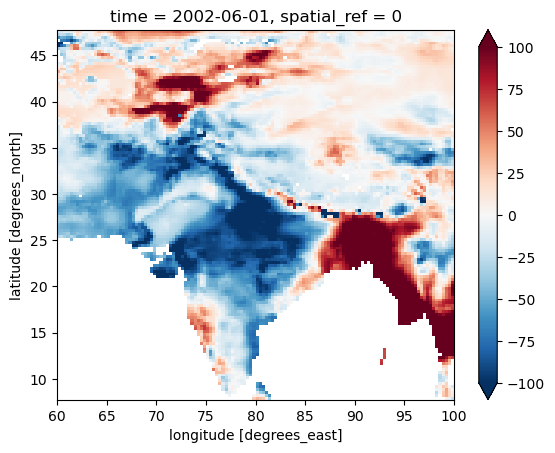

In [12]:
resampled_da[2][2,:,:].plot(cmap='RdBu_r', vmin=-100, vmax=100)

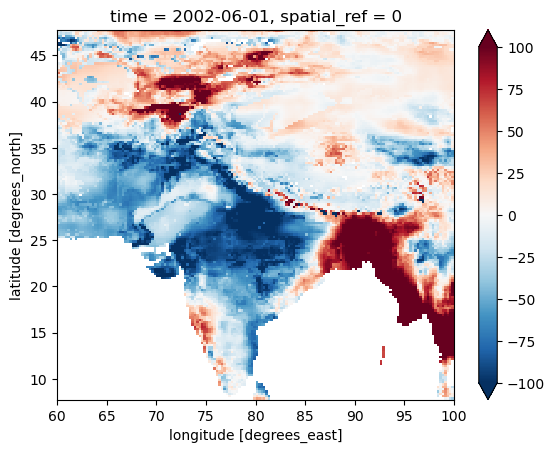

In [13]:
clipped_da[2][2,:,:].plot(cmap='RdBu_r', vmin=-100, vmax=100)